# New England Genomics Center of Excellence

# Set up

This is just an example. We’re going to pull in covid data made from the new york times

**FOR THIS TO WORK:**

1.  run `renv::install('devtools')` if it’s not already installed
2.  then `devtools::install_github("covid19R/covid19nytimes")` if it’s not already installed

In [ ]:
knitr::opts_chunk$set(echo = TRUE, eval = TRUE)

# correlate deaths and cases by state
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

# Create rolling average changes

In [ ]:
# Create rolling average changes
# pivot wider
# this will also be needed when we create lags
us_states <- us_states_long %>%
  # discard dates before cases were tracked.
  filter(date > as.Date("2020-03-01")) %>%
  pivot_wider(names_from = "data_type", values_from = "value") %>%
  rename(state = location) %>%
  select(date, state, cases_total, deaths_total) %>%
  mutate(state = as_factor(state)) %>%
  arrange(state, date) %>%
  group_by(state) %>%
  # smooth the data with 7 day moving average
  mutate(cases_7day = (cases_total - lag(cases_total, 7)) / 7) %>%
  mutate(deaths_7day = (deaths_total - lag(deaths_total, 7)) / 7)

(`geom_line()`).
Removed 7 rows containing missing values or values outside the scale range
(`geom_line()`).

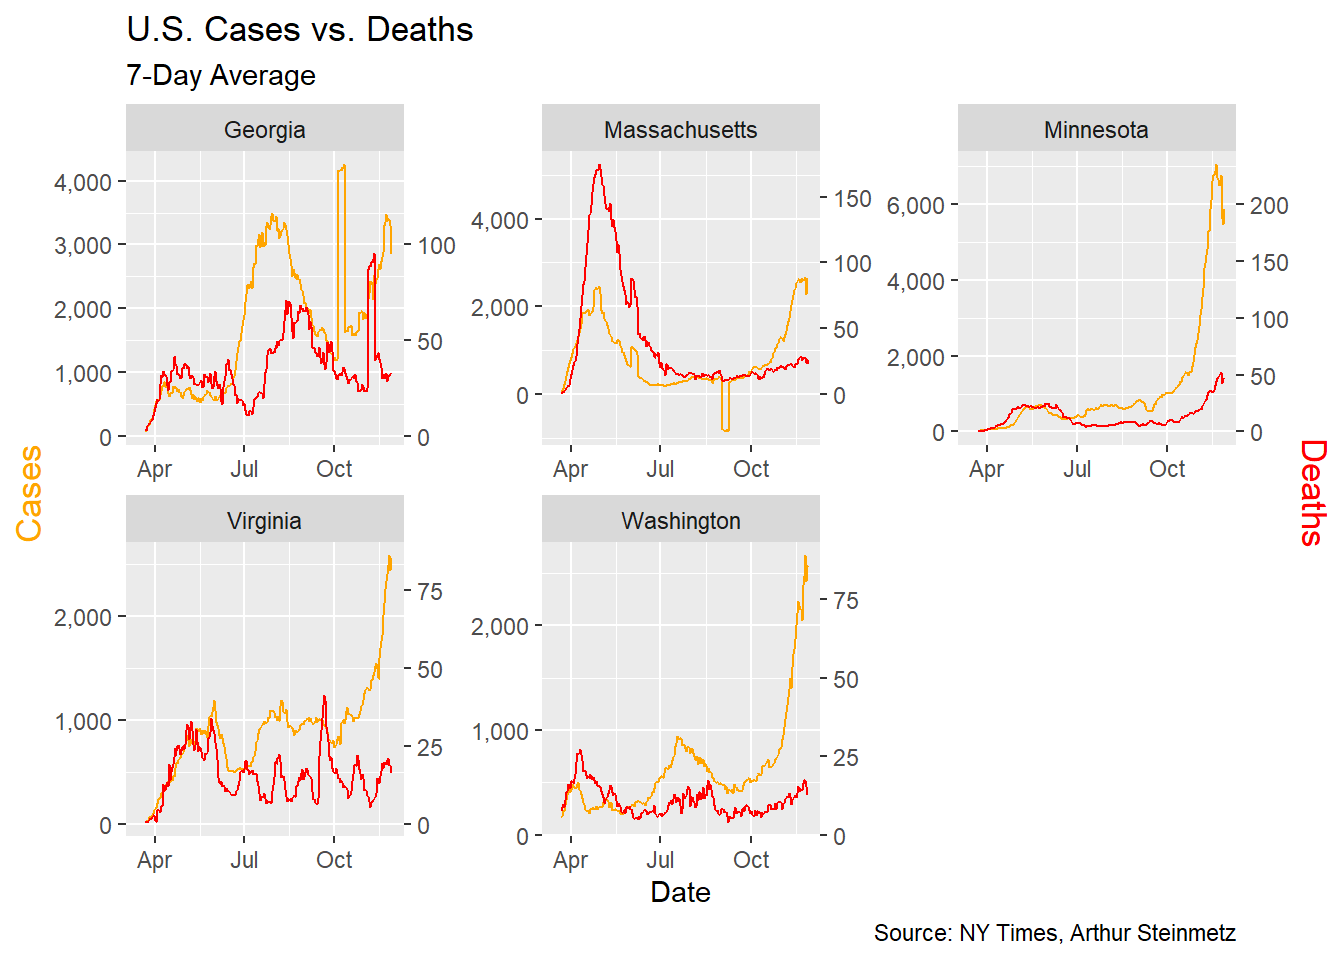

In [ ]:
#| warning: false
#| message: false
#| label: fig-state-analysis
#| fig-cap: "From the New York Times: A couple of observations are obvious. First when cases start to rise, deaths follow with a lag. Second, we have had three spikes in cases so far and in each successive instance the mortality has risen by a smaller amount. This suggests that, thankfully, we are getting better at treating this disease. It is NOT a function of increased testing because positivity rates have not been falling."

# ------------------------------------------
# state by state analysis

coeff <- 30
state_subset <- c("Washington", "Massachusetts", "Georgia", "Minnesota", "Virginia")

# illustrate selected states
g <- us_states %>%
  filter(state %in% state_subset) %>%
  ggplot(aes(date, cases_7day)) +
  geom_line(color = "orange") +
  facet_wrap(~state, scales = "free") +
  theme(legend.position = "none") +
  geom_line(aes(y = deaths_7day * coeff), color = "red") +
  scale_y_continuous(
    labels = scales::comma,
    name = "Cases",
    sec.axis = sec_axis(deaths_7day ~ . / coeff,
      name = "Deaths",
      labels = scales::comma
    )
  ) +
  theme(
    axis.title.y = element_text(color = "orange", size = 13),
    axis.title.y.right = element_text(color = "red", size = 13)
  ) +
  labs(
    title = "U.S. Cases vs. Deaths",
    subtitle = "7-Day Average",
    caption = "Source: NY Times, Arthur Steinmetz",
    x = "Date"
  )
show(g)